<h1>Tests regarding x^2 with different activation functions in neuron class relu,tanh and sigmoid</h1>

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
import math
%matplotlib inline

In [529]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __add__(self,other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value((self.data + other.data),_children = (self,other),_op='+')

        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward

        return out
    def __mul__(self,other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value((self.data * other.data),_children = (self,other),_op='*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    def backwards(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad = 1
        for element in reversed(topo):
            element._backward()

    def __pow__(self, other):
        assert isinstance(other, (int, float))
        out = Value((self.data ** other),_children = (self,),_op='power')

        def _backward():
            self.grad += (other * self.data ** (other-1)) * out.grad
        out._backward = _backward
        return out
    
    
    def exp(self):
        x = self.data
        out = Value((math.exp(x)), (self,) , "exp")
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out
    

    def tanh(self):
        e2x = math.exp(2 * self.data)
        out = Value(((e2x-1)/(e2x+1)),_children = (self, ),_op='tanh')

        def _backward():
            self.grad = 1 - (out.data**2) * out.grad
        out._backward = _backward
        return out
    
    def reLu(self):
        out = Value(0 if self.data < 0 else self.data, (self,), 'ReLU')
        def _backward():
            self.grad += (out.data > 0) * out.grad
        out._backward = _backward
        return out
    
    def __rmul__(self, other):
        return self * other

    def __truediv__(self, other):
        return self * other**-1

    def __neg__(self):
        return self * -1

    def __sub__(self, other):
        return self + (-other)

    def __radd__(self, other):
        return self + other
        
    def __repr__(self):
        return f"Value(data={self.data}, grad={self.grad})"

class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-0.1, 0.1)) for _ in range(nin)]
        self.b = Value(0)
    
    def __call__(self, x):
        act = sum((wi*xi for wi,xi in zip(self.w, x)), self.b)
        return act.reLu()

class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for neuron in layer.neurons for p in neuron.w + [neuron.b]]

def normalize(data):
    min_val = min(d.data[0] for d in data)
    max_val = max(d.data[0] for d in data)
    return [Value([(d.data[0] - min_val) / (max_val - min_val)]) for d in data]

def denormalize(value, min_val, max_val):
    return value * (max_val - min_val) + min_val

def train(model, xs, ys, epochs=5000, learning_rate=0.1):
    for epoch in range(epochs):
        total_loss = 0
        for x, y in zip(xs, ys):
            y_pred = model([x.data[0]])
            
            loss = (y_pred - y.data[0])**2
            total_loss += loss.data

            alpha = 1e-4
            reg_loss = alpha * sum((p*p for p in model.parameters()))
            total_loss += reg_loss
            
            # Backward pass
            for p in model.parameters():
                p.grad = 0
            loss.backwards()
            
            for p in model.parameters():
                p.data += -0.1 * p.grad
        
        if epoch % 500 == 0:
            print(f'Epoch {epoch}, Average Loss: {total_loss.data/len(xs):.4f}')

xs_raw = [Value([x]) for x in [1.0, 2.0, 3.0, 4.0, 5.0]]
ys_raw = [Value([x**2]) for x in [1.0, 2.0, 3.0, 4.0, 5.0]]

xs = normalize(xs_raw)
ys = normalize(ys_raw)

model = MLP(1, [8, 8, 1])

train(model, xs, ys)

def test(model, x):
    x_min, x_max = min(d.data[0] for d in xs_raw), max(d.data[0] for d in xs_raw)
    y_min, y_max = min(d.data[0] for d in ys_raw), max(d.data[0] for d in ys_raw)
    
    x_norm = (x - x_min) / (x_max - x_min)
    y_pred_norm = model([x_norm]).data
    return denormalize(y_pred_norm, y_min, y_max)

test_values = [6.0, 7.0, 8.0, 9.0, 10.0]
for x in test_values:
    predicted = test(model, x)
    actual = x**2
    print(f'x: {x}, Predicted: {predicted:.4f}, Actual: {actual:.4f}')

Epoch 0, Average Loss: 0.2093
Epoch 500, Average Loss: 0.0039
Epoch 1000, Average Loss: 0.0037
Epoch 1500, Average Loss: 0.0036
Epoch 2000, Average Loss: 0.0035
Epoch 2500, Average Loss: 0.0035
Epoch 3000, Average Loss: 0.0035
Epoch 3500, Average Loss: 0.0035
Epoch 4000, Average Loss: 0.0035
Epoch 4500, Average Loss: 0.0035
x: 6.0, Predicted: 32.6454, Actual: 36.0000
x: 7.0, Predicted: 40.1716, Actual: 49.0000
x: 8.0, Predicted: 47.6978, Actual: 64.0000
x: 9.0, Predicted: 55.2240, Actual: 81.0000
x: 10.0, Predicted: 62.7502, Actual: 100.0000


In [531]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __add__(self,other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value((self.data + other.data),_children = (self,other),_op='+')

        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward

        return out
    def __mul__(self,other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value((self.data * other.data),_children = (self,other),_op='*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    def backwards(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad = 1
        for element in reversed(topo):
            element._backward()

    def __pow__(self, other):
        assert isinstance(other, (int, float))
        out = Value((self.data ** other),_children = (self,),_op='power')

        def _backward():
            self.grad += (other * self.data ** (other-1)) * out.grad
        out._backward = _backward
        return out
    
    
    def exp(self):
        x = self.data
        out = Value((math.exp(x)), (self,) , "exp")
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out
    

    def tanh(self):
        e2x = math.exp(2 * self.data)
        out = Value(((e2x-1)/(e2x+1)),_children = (self, ),_op='tanh')

        def _backward():
            self.grad = 1 - (out.data**2) * out.grad
        out._backward = _backward
        return out
    
    def reLu(self):
        out = Value(0 if self.data < 0 else self.data, (self,), 'ReLU')
        def _backward():
            self.grad += (out.data > 0) * out.grad
        out._backward = _backward
        return out
    
    def __rmul__(self, other):
        return self * other

    def __truediv__(self, other):
        return self * other**-1

    def __neg__(self):
        return self * -1

    def __sub__(self, other):
        return self + (-other)

    def __radd__(self, other):
        return self + other

class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-0.1, 0.1)) for _ in range(nin)]
        self.b = Value(0)
    
    def __call__(self, x):
        act = sum((wi*xi for wi,xi in zip(self.w, x)), self.b)
        return act.tanh()

class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for neuron in layer.neurons for p in neuron.w + [neuron.b]]

def normalize(data):
    min_val = min(d.data[0] for d in data)
    max_val = max(d.data[0] for d in data)
    return [Value([(d.data[0] - min_val) / (max_val - min_val)]) for d in data]

def denormalize(value, min_val, max_val):
    return value * (max_val - min_val) + min_val

def train(model, xs, ys, epochs=5000, learning_rate=10):
    for epoch in range(epochs):
        total_loss = 0
        for x, y in zip(xs, ys):
            y_pred = model([x.data[0]])
            
            loss = (y_pred - y.data[0])**2
            total_loss += loss.data

            alpha = 1e-4
            reg_loss = alpha * sum((p*p for p in model.parameters()))
            total_loss += reg_loss
            
            # Backward pass
            for p in model.parameters():
                p.grad = 0
            loss.backwards()
            
            for p in model.parameters():
                p.data += -0.1 * p.grad
        
        if epoch % 500 == 0:
            print(f'Epoch {epoch}, Average Loss: {total_loss.data/len(xs):.4f}')

xs_raw = [Value([x]) for x in [1.0, 2.0, 3.0, 4.0, 5.0]]
ys_raw = [Value([x**2]) for x in [1.0, 2.0, 3.0, 4.0, 5.0]]

xs = normalize(xs_raw)
ys = normalize(ys_raw)

model = MLP(1, [8, 8, 1])

train(model, xs, ys)

def test(model, x):
    x_min, x_max = min(d.data[0] for d in xs_raw), max(d.data[0] for d in xs_raw)
    y_min, y_max = min(d.data[0] for d in ys_raw), max(d.data[0] for d in ys_raw)
    
    x_norm = (x - x_min) / (x_max - x_min)
    y_pred_norm = model([x_norm]).data
    return denormalize(y_pred_norm, y_min, y_max)

test_values = [6.0, 7.0, 8.0, 9.0, 10.0]
for x in test_values:
    predicted = test(model, x)
    actual = x**2
    print(f'x: {x}, Predicted: {predicted:.4f}, Actual: {actual:.4f}')

Epoch 0, Average Loss: 0.9378


OverflowError: math range error

In [250]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __add__(self,other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value((self.data + other.data),_children = (self,other),_op='+')

        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward

        return out
    def __mul__(self,other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value((self.data * other.data),_children = (self,other),_op='*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    def backwards(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad = 1
        for element in reversed(topo):
            element._backward()

    def __pow__(self, other):
        assert isinstance(other, (int, float))
        out = Value((self.data ** other),_children = (self,),_op='power')

        def _backward():
            self.grad += (other * self.data ** (other-1)) * out.grad
        out._backward = _backward
        return out
    
    
    def exp(self):
        x = self.data
        out = Value((math.exp(x)), (self,) , "exp")
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out
    

    def tanh(self):
        e2x = math.exp(2 * self.data)
        out = Value(((e2x-1)/(e2x+1)),_children = (self, ),_op='tanh')

        def _backward():
            self.grad = 1 - (out.data**2) * out.grad
        out._backward = _backward
        return out
    
    def reLu(self):
        out = Value(0 if self.data < 0 else self.data, (self,), 'ReLU')
        def _backward():
            self.grad += (out.data > 0) * out.grad
        out._backward = _backward
        return out
        
    def sigmoid(self):
        s = 1 / (1 + np.exp(-self.data))
        out = Value(s, (self,), 'Sigmoid')
        
        def _backward():
            sigmoid_grad = s * (1 - s)
            self.grad += sigmoid_grad * out.grad
        
        out._backward = _backward
        return out
    
    def __rmul__(self, other):
        return self * other

    def __truediv__(self, other):
        return self * other**-1

    def __neg__(self):
        return self * -1

    def __sub__(self, other):
        return self + (-other)

    def __radd__(self, other):
        return self + other

class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-0.1, 0.1)) for _ in range(nin)]
        self.b = Value(0)
    
    def __call__(self, x):
        act = sum((wi*xi for wi,xi in zip(self.w, x)), self.b)
        return act.sigmoid()

class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for neuron in layer.neurons for p in neuron.w + [neuron.b]]

def normalize(data):
    min_val = min(d.data[0] for d in data)
    max_val = max(d.data[0] for d in data)
    return [Value([(d.data[0] - min_val) / (max_val - min_val)]) for d in data]

def denormalize(value, min_val, max_val):
    return value * (max_val - min_val) + min_val

def train(model, xs, ys, epochs=5000, learning_rate=0.01):
    for epoch in range(epochs):
        total_loss = 0
        for x, y in zip(xs, ys):
            y_pred = model([x.data[0]])
            
            loss = (y_pred - y.data[0])**2
            total_loss += loss.data

            alpha = 1e-3
            reg_loss = alpha * sum((p*p for p in model.parameters()))
            total_loss += reg_loss
            
            # Backward pass
            for p in model.parameters():
                p.grad = 0
            loss.backwards()
            
            for p in model.parameters():
                p.data += -0.1 * p.grad
        
        if epoch % 500 == 0:
            print(f'Epoch {epoch}, Average Loss: {total_loss.data/len(xs):.4f}')

xs_raw = [Value([x]) for x in [1.0, 2.0, 3.0, 4.0, 5.0]]
ys_raw = [Value([x**2]) for x in [1.0, 2.0, 3.0, 4.0, 5.0]]

xs = normalize(xs_raw)
ys = normalize(ys_raw)

model = MLP(1, [4, 1])

train(model, xs, ys)

def test(model, x):
    x_min, x_max = min(d.data[0] for d in xs_raw), max(d.data[0] for d in xs_raw)
    y_min, y_max = min(d.data[0] for d in ys_raw), max(d.data[0] for d in ys_raw)
    
    x_norm = (x - x_min) / (x_max - x_min)
    y_pred_norm = model([x_norm]).data
    return denormalize(y_pred_norm, y_min, y_max)

test_values = [6.0, 7.0, 8.0, 9.0, 10.0]
for x in test_values:
    predicted = test(model, x)
    actual = x**2
    print(f'x: {x}, Predicted: {predicted:.4f}, Actual: {actual:.4f}')

Epoch 0, Average Loss: 0.1415
Epoch 500, Average Loss: 0.0879
Epoch 1000, Average Loss: 0.0531
Epoch 1500, Average Loss: 0.0610
Epoch 2000, Average Loss: 0.0648
Epoch 2500, Average Loss: 0.0671
Epoch 3000, Average Loss: 0.0689
Epoch 3500, Average Loss: 0.0706
Epoch 4000, Average Loss: 0.0723
Epoch 4500, Average Loss: 0.0739
x: 6.0, Predicted: 24.2716, Actual: 36.0000
x: 7.0, Predicted: 24.6575, Actual: 49.0000
x: 8.0, Predicted: 24.7799, Actual: 64.0000
x: 9.0, Predicted: 24.8277, Actual: 81.0000
x: 10.0, Predicted: 24.8494, Actual: 100.0000


<h1>Iris dataset done with tensorflow</h1>

In [424]:
import pandas as pd

data = pd.read_csv('/Users/regiloshi/Downloads/archive/Iris.csv')
X = data.drop(columns=['Species'])
y = data['Species']

In [426]:
y

0         Iris-setosa
1         Iris-setosa
2         Iris-setosa
3         Iris-setosa
4         Iris-setosa
            ...      
145    Iris-virginica
146    Iris-virginica
147    Iris-virginica
148    Iris-virginica
149    Iris-virginica
Name: Species, Length: 150, dtype: object

In [428]:
print(y.shape)

(150,)


In [430]:
y = y.to_numpy().reshape(-1,1)
print(y.shape)

(150, 1)


In [432]:
X

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
0,1,5.1,3.5,1.4,0.2
1,2,4.9,3.0,1.4,0.2
2,3,4.7,3.2,1.3,0.2
3,4,4.6,3.1,1.5,0.2
4,5,5.0,3.6,1.4,0.2
...,...,...,...,...,...
145,146,6.7,3.0,5.2,2.3
146,147,6.3,2.5,5.0,1.9
147,148,6.5,3.0,5.2,2.0
148,149,6.2,3.4,5.4,2.3


In [434]:
data.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


In [436]:
data.describe()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,75.500000,5.843333,3.054000,3.758667,1.198667
std,43.445368,0.828066,0.433594,1.764420,0.763161
min,1.000000,4.300000,2.000000,1.000000,0.100000
25%,38.250000,5.100000,2.800000,1.600000,0.300000
50%,75.500000,5.800000,3.000000,4.350000,1.300000
75%,112.750000,6.400000,3.300000,5.100000,1.800000
max,150.000000,7.900000,4.400000,6.900000,2.500000


In [438]:
data.shape

(150, 6)

In [440]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Input

In [442]:
one_hot_encoder = OneHotEncoder(sparse_output=False)
y_encoded = one_hot_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42)

In [444]:
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (105, 5)
X_test shape: (45, 5)
y_train shape: (105, 3)
y_test shape: (45, 3)


In [446]:
nn = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(units=10,activation='relu'),
    Dense(units=10, activation='relu'),
    Dense(units=3, activation='softmax')    
          ])

In [448]:
nn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

nn.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_25 (Dense)                │ (None, 10)             │            60 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 3)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 203 (812.00 B)

 Trainable params: 203 (812.00 B)

 Non-trainable params: 0 (0.00 B)

In [450]:
nn.fit(X_train,y_train,epochs=100)

Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3493 - loss: 5.0177  
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step - accuracy: 0.3691 - loss: 4.0622
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3389 - loss: 3.5568 
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 886us/step - accuracy: 0.3680 - loss: 3.8613
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1991 - loss: 3.8219 
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step - accuracy: 0.3597 - loss: 3.3660
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3587 - loss: 3.4436 
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 879us/step - accuracy: 0.3118 - loss: 2.8744
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step - accuracy: 0.2452 - loss: 2.6243
Epoch 10/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step - accuracy: 0.2237 - loss: 3.0630
Epoch 11/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 891us/step - accuracy: 0.3188 - loss: 2.3440
Epoch 12/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step - accuracy: 0.

In [452]:
loss, accuracy = model.evaluate(X_test, y_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9748 - loss: 0.2139 


In [ ]:
functions which i have tried to calculate the gradient of myself

In [468]:
from graphviz import Digraph
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ data %.4f | grad %.4f }" % (n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

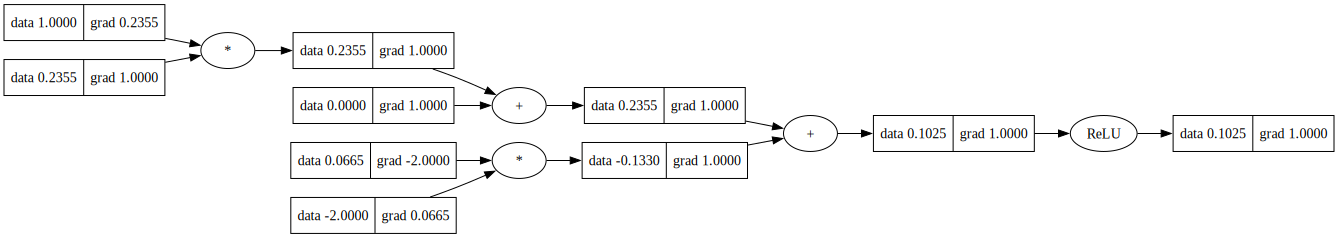

In [496]:
a = Value(1)
b = Value(0.2355)
c = a * b
k = Value(0)
d = Value(0.0665)
e = Value(-2)
f = k + c
g = d * e
l = f + g
r = l.reLu()
r.backwards()
draw_dot(r)

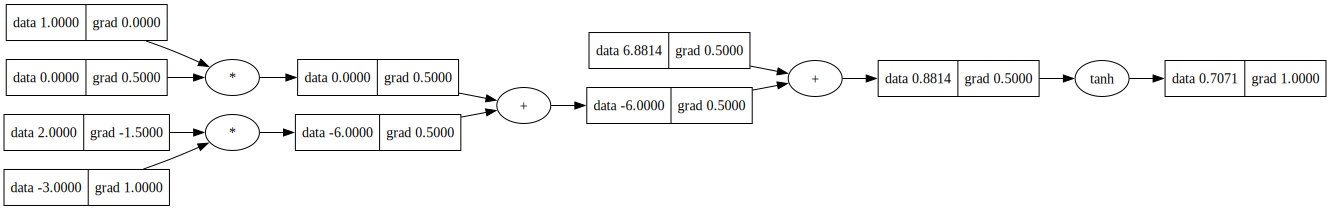

In [498]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backwards()
draw_dot(o)

<h1>iris dataset done with micrograd and nn class</h1>

In [593]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __add__(self,other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value((self.data + other.data),_children = (self,other),_op='+')

        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward

        return out
    def __mul__(self,other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value((self.data * other.data),_children = (self,other),_op='*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    def backwards(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad = 1
        for element in reversed(topo):
            element._backward()

    def __pow__(self, other):
        assert isinstance(other, (int, float))
        out = Value((self.data ** other),_children = (self,),_op='power')

        def _backward():
            self.grad += (other * self.data ** (other-1)) * out.grad
        out._backward = _backward
        return out
    
    
    def exp(self):
        x = self.data
        out = Value((math.exp(x)), (self,) , "exp")
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out
    

    def tanh(self):
        e2x = math.exp(2 * self.data)
        out = Value(((e2x-1)/(e2x+1)),_children = (self, ),_op='tanh')

        def _backward():
            self.grad = 1 - (out.data**2) * out.grad
        out._backward = _backward
        return out
    
    def reLu(self):
        out = Value(0 if self.data < 0 else self.data, (self,), 'ReLU')
        def _backward():
            self.grad += (out.data > 0) * out.grad
        out._backward = _backward
        return out
    
    def __rmul__(self, other):
        return self * other

    def __truediv__(self, other):
        return self * other**-1

    def __neg__(self):
        return self * -1

    def __sub__(self, other):
        return self + (-other)

    def __radd__(self, other):
        return self + other
        
    def __repr__(self):
        return f"Value(data={self.data}, grad={self.grad})"

class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-0.1, 0.1)) for _ in range(nin)]
        self.b = Value(0)
    
    def __call__(self, x):
        act = sum((wi*xi for wi,xi in zip(self.w, x)), self.b)
        return act.reLu()

class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for neuron in layer.neurons for p in neuron.w + [neuron.b]]

In [595]:
from sklearn import datasets
from sklearn.model_selection import train_test_split

iris = datasets.load_iris()
X, y = iris.data, iris.target

In [597]:
X_values = [[Value([x]) for x in row] for row in X]
y_values = [Value([yi]) for yi in y]

In [599]:
X_norm = [normalize(x) for x in zip(*X_values)]
y_norm = normalize(y_values)

In [601]:
X_train, X_test, y_train, y_test = train_test_split(list(zip(*X_norm)), y_norm, test_size=0.2, random_state=42)

In [603]:
print(len(X_train))

120


In [605]:
print(len(X_test))

30


In [607]:
model = MLP(4, [8, 8, 1])

In [621]:
def train(model, X, y, epochs=5000, learning_rate=0.01):
    for epoch in range(epochs):
        total_loss = 0
        for x, y_true in zip(X, y):
            y_pred = model([xi.data[0] for xi in x])
            
            loss = (y_pred - y_true.data[0])**2
            total_loss += loss.data
            alpha = 1e-3
            reg_loss = alpha * sum((p*p for p in model.parameters()))
            total_loss += reg_loss.data
            
            for p in model.parameters():
                p.grad = 0
            loss.backwards()
            
            for p in model.parameters():
                p.data += -learning_rate * p.grad
        
        if epoch % 500 == 0:
            print(f'Epoch {epoch}, Average Loss: {total_loss/len(X):.4f}')

In [623]:
train(model,X_train,y_train)

Epoch 0, Average Loss: 0.1673
Epoch 500, Average Loss: 0.0137
Epoch 1000, Average Loss: 0.0140


KeyboardInterrupt: 

In [625]:
def evaluate(model, X, y):
    total_examples = len(X)
    correct_found = 0
    for xs, y_true in zip(X, y):
        y_hat = model([x.data[0] for x in xs])
        if abs(y_hat.data - y_true.data[0]) < 0.1:
            correct_found+=1
    return correct_found/total_examples

train_accuracy = evaluate(model, X_train, y_train)
print(f"Training accuracy: {train_accuracy:.4f}")

test_accuracy = evaluate(model, X_test, y_test)
print(f"Test accuracy: {test_accuracy:.4f}")

Training accuracy: 0.8167
Test accuracy: 0.7667
